In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Dense,Reshape,Dropout
from keras.layers import Input,LSTM,Lambda,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

from scripts.model import data_preperation as preperation
from scripts.model import model as cnn_lstm
from scripts.model import evaluation as evaluation

Using TensorFlow backend.


---

# Start

# 1. Prepare Data for CNN-LSTM

In [3]:
# Data Parameter
aggregate = False
rolling_days = 2
evaluation_split_day = "2019-05-01"
testtraining_split_day = "2018-06-01"

# Model Parameter
dropout = 0.5
learning_rate = 1e-2
epochs = 40
batch_size = 32

In [4]:
logging.info('Import model data')
df = preperation.import_model_data("data/Stromfluss/",'data/additional_input.csv',aggregate)

logging.info('Enrich with daily information')
df = preperation.extract_daily_informatin(df)


# Configurations
countries = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
import_cols = [col+ "_IM" for col in countries]
export_cols = [col+ "_EX" for col in countries]

if not aggregate:
    countries = [col+ "_"+ nx_type for col in countries for nx_type in ['EX','IM']]

ind = ['Date','Tag','NX']
additional_input_columns = [col for col in df.columns  if (col not in countries) and (col not in ind) ]


logging.info('Gather maximum capacities')
export_max_capa = df[export_cols].max()
import_max_capa = df[import_cols].min()

logging.info('Remove Outlier')
df = preperation.remove_outlier(df, countries)

logging.info('Scale Data')
df,scaler = preperation.scale_data(df,countries,additional_input_columns)

Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201706020000_201906022359_1.csv 


In [5]:
logging.info('Aggregate Data for CNN')
df_nx = preperation.aggregate_nx(df, countries,rolling_days)
df_addx = preperation.aggregate_additional_input_data(df, additional_input_columns,rolling_days)

# Merge to master
df_master = pd.merge(df_nx,df_addx,on="Tag")
df_master['X_Attributes'] = df_master.apply(lambda row: np.concatenate((row.NX_per_country_shifted,row.Additional_X_aggregated),axis=1), axis=1 )
df_master.drop(['NX_per_country_shifted','Additional_X_aggregated'],axis=1,inplace=True)

logging.info('Evaluation Split')
df_eval = df_master.loc[df_master.Tag>evaluation_split_day].reset_index(drop=True)
df_master = df_master.loc[df_master.Tag<=evaluation_split_day]

logging.info('Test/Training Split')
test = df_master.loc[df_master.Tag>testtraining_split_day]
train = df_master.loc[df_master.Tag<=testtraining_split_day]
testX = test[['X_Attributes']].values
testY = test[['NX_per_country']].values
trainX = train[['X_Attributes']].values
trainY = train[['NX_per_country']].values

trainX, trainY, testX, testY = preperation.reformat_data_for_training(trainX, trainY, testX, testY)
print("Traings Data Shape:\n X: {} Y: {}".format(trainX.shape,trainY.shape))
print("Testing Data Shape:\n X: {} Y: {}".format(testX.shape,testY.shape))

Traings Data Shape:
 X: (1095, 1, 48, 85) Y: (1095, 24, 18)
Testing Data Shape:
 X: (334, 1, 48, 85) Y: (334, 24, 18)


---

# Config and Initialize Model

In [6]:
def create_model(dropout,countries,add_x,rolling_days):
    num_features = len(countries+add_x)
    channels = 1
    InputShape = (channels,24*rolling_days,num_features)
    inputs = Input(shape=InputShape)
    
    x = inputs
    x = Conv2D(32,kernel_size=(2,1),strides=1,data_format="channels_first",padding='same')(x)
    x = Activation("relu")(x)
    x = Conv2D(1,1,data_format="channels_first")(x)
    x = Lambda(lambda x: x[:,0,:,:])(x)
    
    
    x = LSTM(100 , return_sequences=True)(x)

    if rolling_days>1:
        x = Lambda(lambda x: x[:,-24::,:])(x)
    
    x = Dropout(dropout)(x)
    x = Flatten()(x)
    x = Dense(24*len(countries))(x)
    x = Reshape((24, len(countries)))(x)
    
    return Model(inputs, x)

In [7]:
model = create_model(dropout,countries,additional_input_columns,rolling_days)
opt = Adam(lr=learning_rate)
model.compile(loss="mae", optimizer=opt)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
decay_schedule = lambda x: 1e-4 if x>=30 else 1e-3 if x>=10 else learning_rate
ls = LearningRateScheduler(decay_schedule,verbose=1)

W0720 18:41:09.373401 140735615763328 deprecation_wrapper.py:119] From /Users/zcjr/Documents/VirtualEnv/python_3.7_virtEnv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 18:41:09.388261 140735615763328 deprecation_wrapper.py:119] From /Users/zcjr/Documents/VirtualEnv/python_3.7_virtEnv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 18:41:09.392880 140735615763328 deprecation_wrapper.py:119] From /Users/zcjr/Documents/VirtualEnv/python_3.7_virtEnv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 18:41:09.406094 140735615763328 deprecation_wrapper.py:119] From /Users/zcjr/Documents/VirtualEnv/python_3.7_virtEnv/lib/python3.7/site-packages/keras/back

Train on 1095 samples, validate on 334 samples
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
1095/1095 [==============================] - 6s 6ms/step - loss: 0.2716 - val_loss: 0.1439

Epoch 00001: val_loss improved from inf to 0.14388, saving model to best_model.h5
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
1095/1095 [==============================] - 5s 5ms/step - loss: 0.1156 - val_loss: 0.1249

Epoch 00002: val_loss improved from 0.14388 to 0.12487, saving model to best_model.h5
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
1095/1095 [==============================] - 5s 5ms/step - loss: 0.1046 - val_loss: 0.1222

Epoch 00003: val_loss improved from 0.12487 to 0.12221, saving model to best_model.h5
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
1095/1095 [==============================] - 6s 5ms/step - loss: 0.0993 - val_loss: 0.1190

Epoch 00004: val_lo

1095/1095 [==============================] - 6s 5ms/step - loss: 0.0764 - val_loss: 0.0986

Epoch 00034: val_loss did not improve from 0.09852
Epoch 00034: early stopping


# 3. Train Model

In [ ]:
logging.info('Train Model')
train_history = model.fit(
    trainX, 
    trainY,
    validation_data=(testX, testY),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es, mc,ls]
)

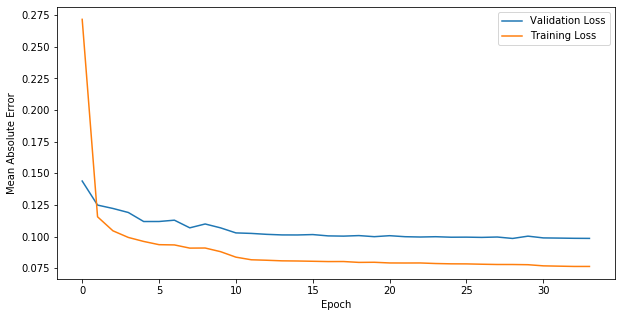

In [8]:
cnn_lstm.plot_train_history(train_history)

---

# 4. Evaluate Model

In [9]:
logging.info("Evaluation")
model = load_model('best_model.h5')

/Users/zcjr/Documents/VirtualEnv/python_3.7_virtEnv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


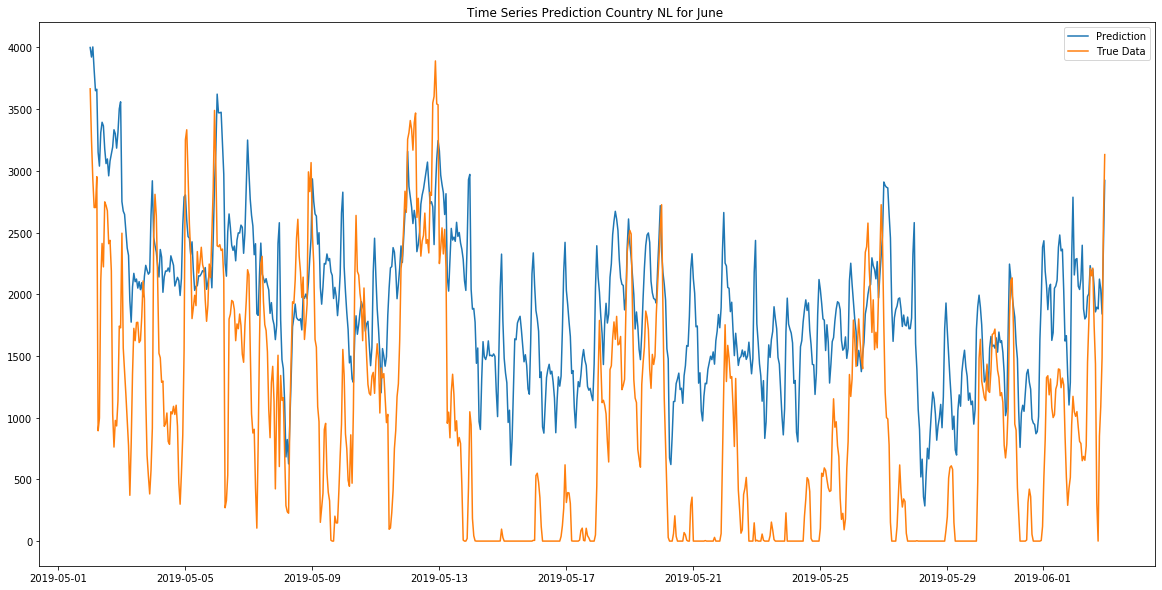

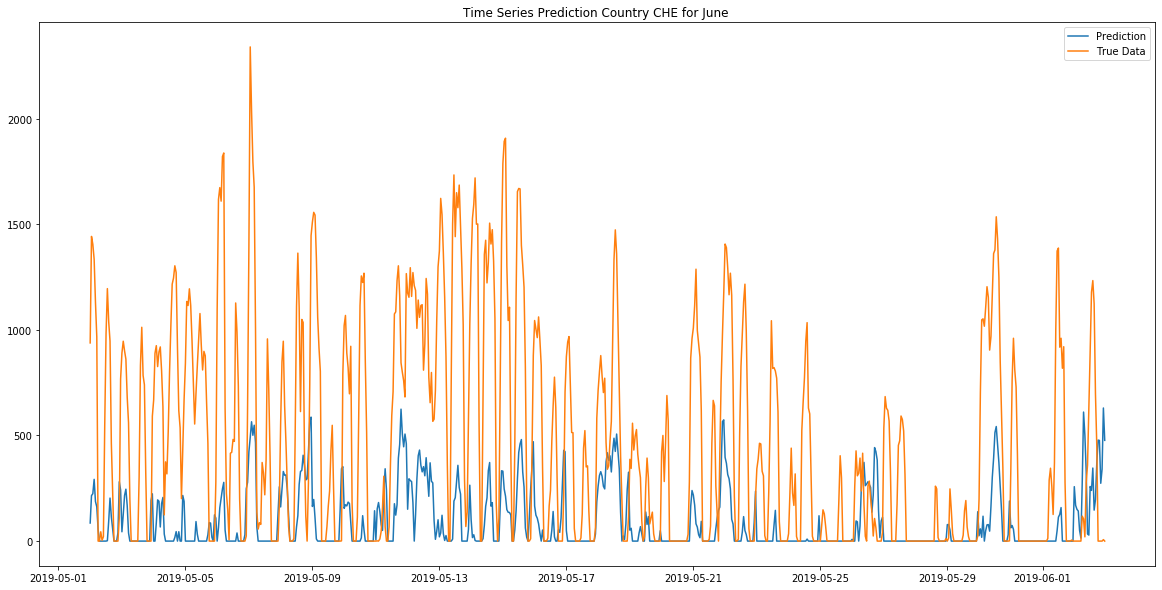

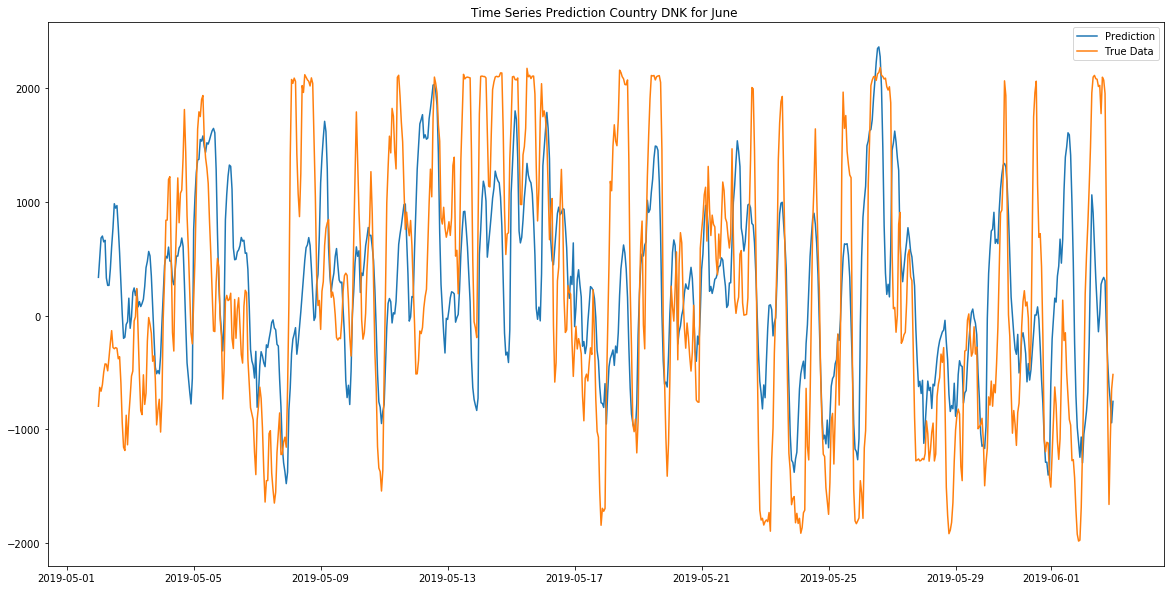

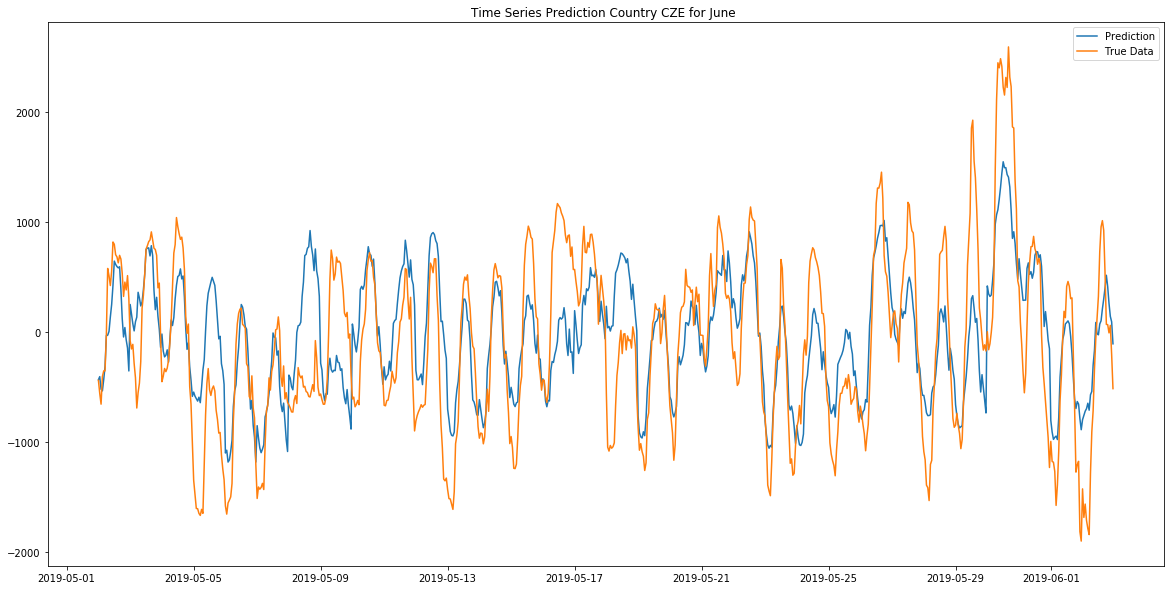

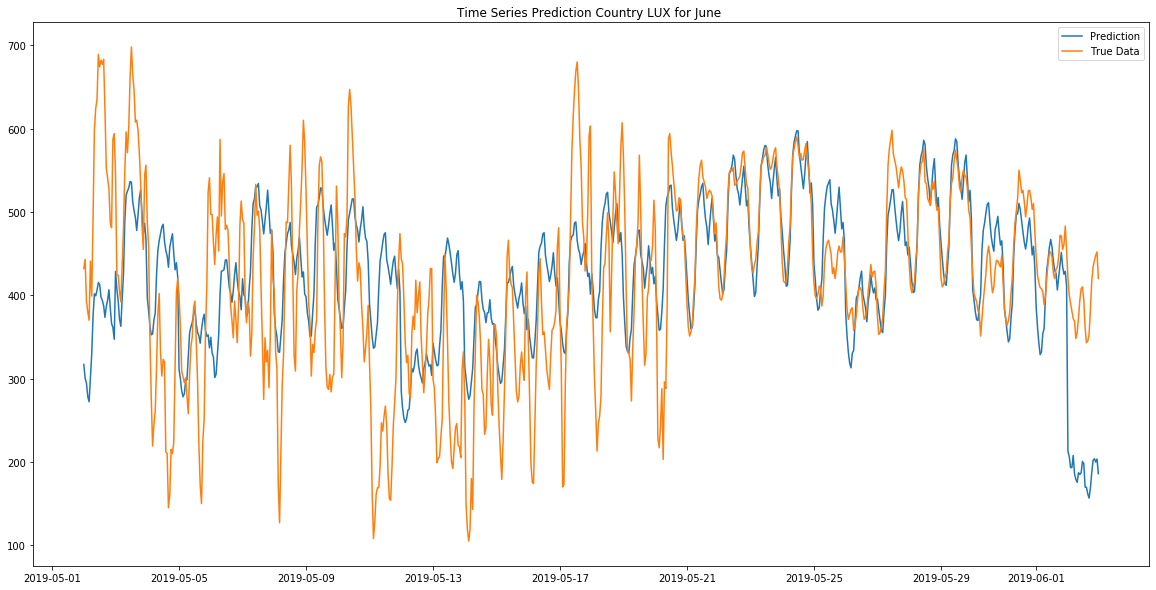

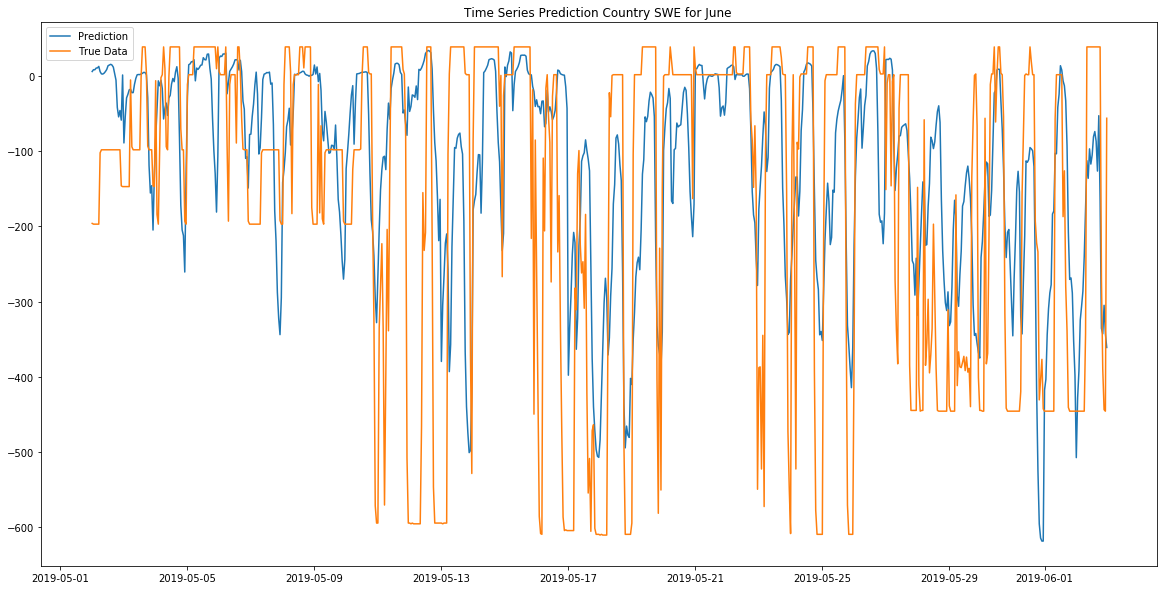

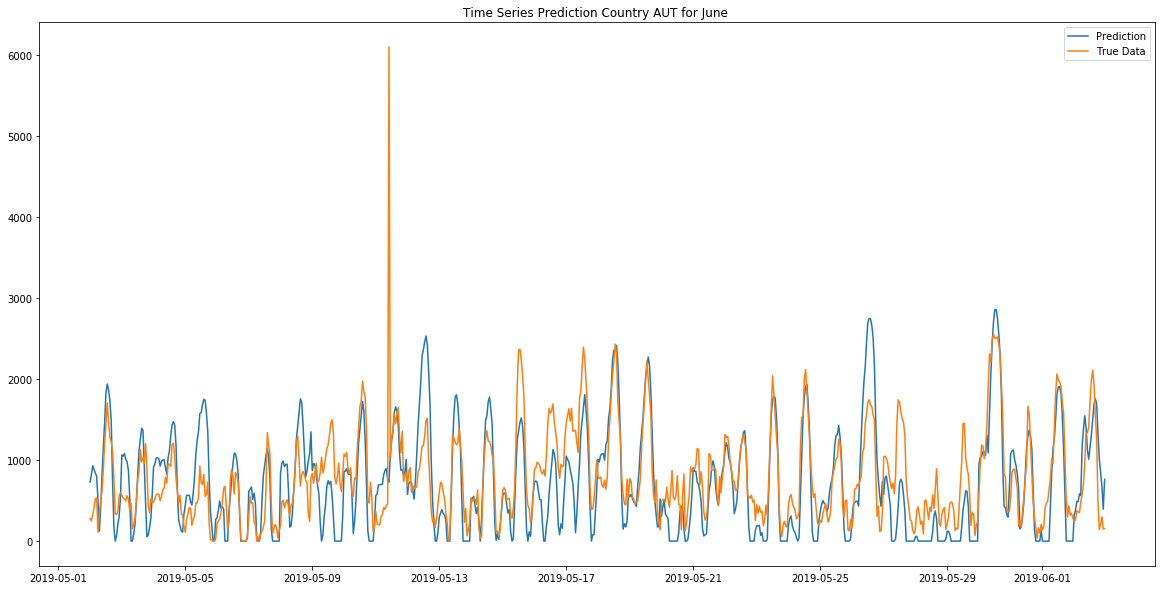

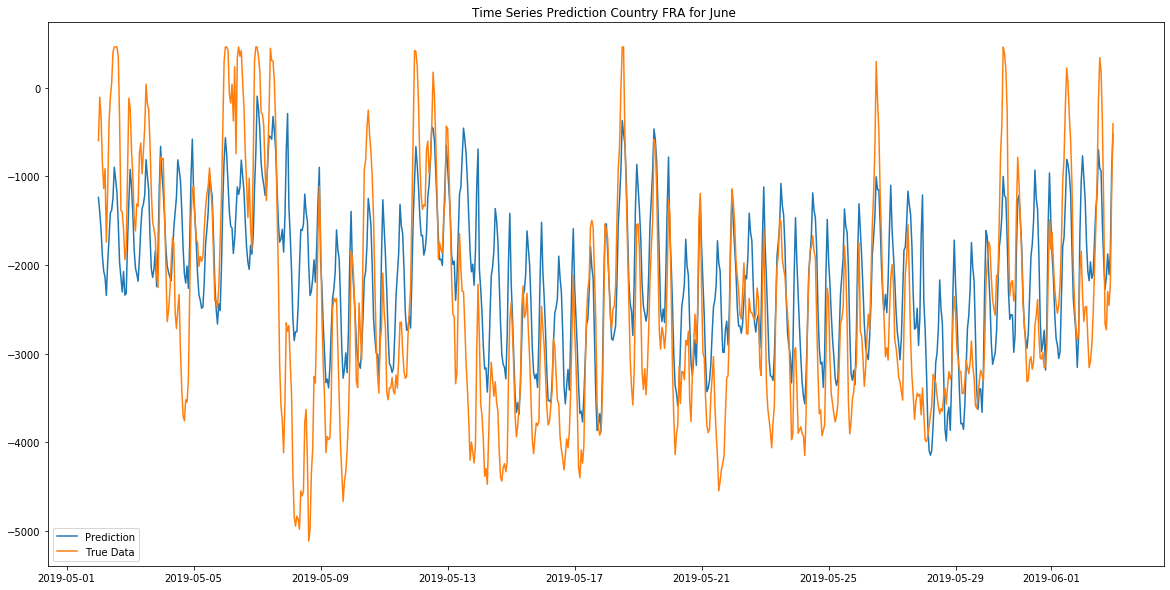

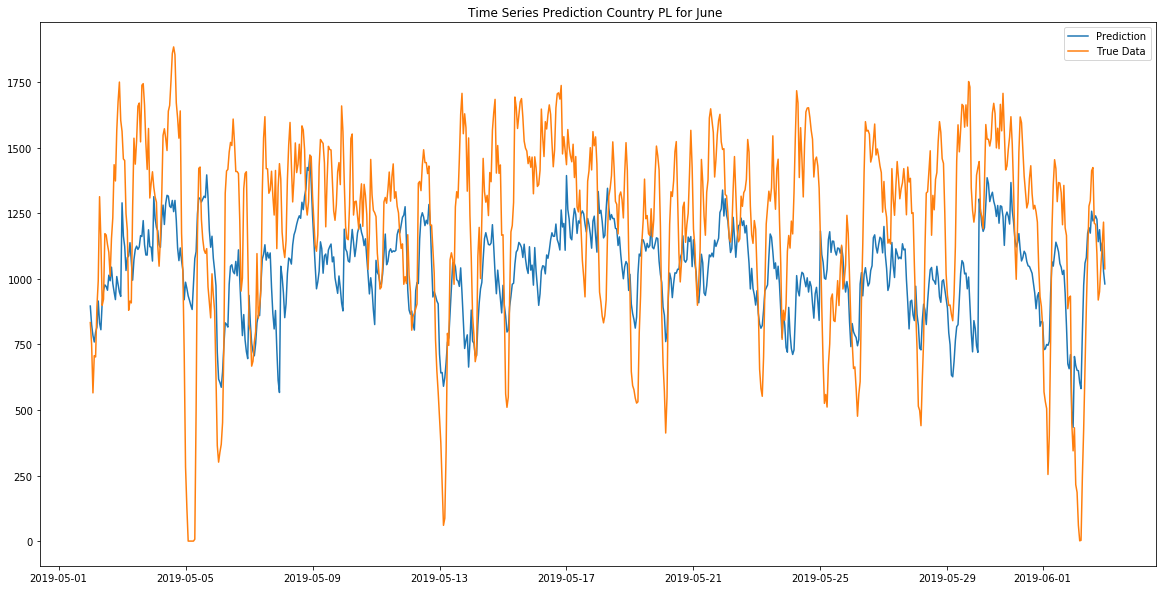

MAE:
NL     1014.869373
CHE     424.729647
DNK     774.077456
CZE     423.717290
LUX      73.351606
SWE     131.588587
AUT     337.687541
FRA     733.771673
PL      289.982444
dtype: float64

Gesamt:467.086179622107


In [10]:
aggregate_prediction = True

df_predictions , df_true_test_values = evaluation.predict(model,df_eval,countries)
df_predictions[countries] = scaler.inverse_transform(df_predictions[countries])
df_true_test_values[countries] = scaler.inverse_transform(df_true_test_values[countries])

df_predictions = evaluation.apply_expert_knowledge(df_predictions,import_cols,export_cols,import_max_capa,export_max_capa)

if aggregate_prediction:
    cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
    df_predictions , df_true_test_values = evaluation.aggregate_to_country(df_predictions, df_true_test_values)
    evaluation.plot_and_calculate_error(df_predictions,df_true_test_values,cols)      
else:
    evaluation.plot_and_calculate_error(df_predictions,df_true_test_values,countries)